# importing libraries

In [2]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
import numpy as np
from sklearn.preprocessing import StandardScaler



In [3]:
diabetes = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(diabetes.data,
diabetes.target, random_state=2506)


## Lasso

In [4]:
lasso = Lasso().fit(X_train,y_train)
print("R^2 train = ",lasso.score(X_train,y_train))
print("R^2 test = ",lasso.score(X_test,y_test))
print("number of features used = ",np.sum(lasso.coef_!= 0))
d=np.array(diabetes.feature_names)
print("The features used are", d[lasso.coef_!=0])


R^2 train =  0.35977425731756085
R^2 test =  0.32079824809111557
number of features used =  2
The features used are ['bmi' 's5']


In [6]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Scaled dataset results

In [8]:
lasso = Lasso().fit(X_train_scaled,y_train)
print("R^2 train = ",lasso.score(X_train_scaled,y_train))
print("R^2 test = ",lasso.score(X_test_scaled,y_test))
print("number of features used = ",np.sum(lasso.coef_!= 0))

print("The features used are",d[lasso.coef_!=0])


R^2 train =  0.518543652885116
R^2 test =  0.4773660349218095
number of features used =  8
The features used are ['age' 'sex' 'bmi' 'bp' 's1' 's3' 's4' 's5']


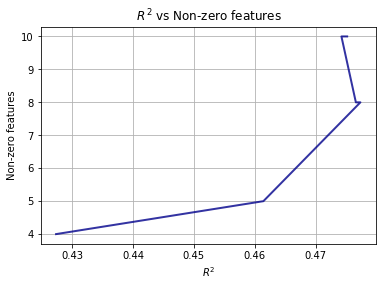

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
score=np.zeros(8)
features=np.zeros(8)
count=0
for i in [10,5,1,0.5,0.1,0.01,0.001,0.001]:
#np.logspace(-1, -5, num=100,base=5):
    lasso=Lasso(alpha=i,max_iter=10000).fit(X_train_scaled,y_train)
    score[count]=lasso.score(X_test_scaled,y_test)
    features[count]=np.sum(lasso.coef_!= 0)
    count+=1
plt.plot(score,features,color="darkblue", alpha=0.8, linewidth=2) 
plt.ylabel('Non-zero features') 
plt.xlabel('$R^2$')

plt.title(' $R^2$ vs Non-zero features ')
plt.grid()


    

- Since we are handling moderate number of features(=10), it is fine to have a complex model that will not be  too costly. The point on the curve (0.477,8) seems to be optimal as it considered only 8 featureas to train and gives high $R^2$ compared to other scores.

## cross validation results

In [10]:
from sklearn.model_selection import GridSearchCV
alpha_finder=GridSearchCV(Lasso(),param_grid={'alpha':[10,5,1,0.5,0.1,0.01,0.001,0.001]},cv=5).fit(X_train_scaled, y_train).best_estimator_
lasso = Lasso(alpha=alpha_finder.alpha).fit(X_train_scaled,y_train)
print("optimal alpha",alpha_finder.alpha)
print("R^2 train = ",lasso.score(X_train_scaled,y_train))
print("R^2 test = ",lasso.score(X_test_scaled,y_test))
print("number of features used = ",np.sum(lasso.coef_!= 0))

optimal alpha 1
R^2 train =  0.5185416330587983
R^2 test =  0.47736711807751186
number of features used =  8


/home/cim/pgt/mhac062/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# inductive conformal prediction

In [11]:
def inductive_conform_pred(X,y,epsilon):
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=2506)
    X_train_proper, X_calibration, y_train_proper, y_calibration = train_test_split(X_train,y_train,test_size=0.299,random_state=2506)
    scaler = StandardScaler()
    scaler.fit(X_train_proper)
    X_train_proper_scaled = scaler.transform(X_train_proper)
    X_calibration_scaled = scaler.transform(X_calibration)
    X_test_scaled = scaler.transform(X_test)

    alpha_finder=GridSearchCV(Lasso(),param_grid={'alpha':[10,5,1,0.5,0.1,0.05,0.001,0.005,0.001]},cv=5).fit(X_train_proper_scaled, y_train_proper).best_estimator_
    lasso=Lasso(alpha=alpha_finder.alpha).fit(X_train_proper_scaled, y_train_proper)
    pred_calibration = lasso.predict(X_calibration_scaled)
    pred_test=lasso.predict(X_test_scaled)
    conform_scores=np.zeros(X_calibration_scaled.shape[0])
    for i in range(X_calibration_scaled.shape[0]):
        conform_scores[i]=abs(y_calibration[i]-pred_calibration[i])
    conform_scores=np.sort(conform_scores, axis=None) 
    k=(1-(epsilon/100))*(X_calibration_scaled.shape[0]+1)
    c=conform_scores[int(k)-1]
    inter_test=[]
    for i in range(X_test.shape[0]):
        inter_test.append([pred_test[i]-c,pred_test[i]+c])
    test=np.zeros(X_test_scaled.shape[0])
    j=0
    for i in inter_test:
        if y_test[j]>=i[0]:
            test[j]=1
        else:
            test[j]=0
        j+=1 
            
    print("interval is ",c) 
   
    print("test_error_rate is ",(sum(test==0)/test.shape[0])) 
    

# for significance 95% and 80%

In [12]:
inductive_conform_pred(X,y,5)

         
    

interval is  106.47706659141119
test_error_rate is  0.018018018018018018


/home/cim/pgt/mhac062/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [13]:
inductive_conform_pred(X,y,20)

interval is  73.32442700001351
test_error_rate is  0.05405405405405406


/home/cim/pgt/mhac062/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
